# Geostat workflow

The main idea of this page is to show the step by step geostatistical workflow. In order to check the quality of the procedure, the data are simulated with a given covariance.

The aim is then to identify the variogram, run the cross validation, and make some predictions.

Still in development !

January 2018 - P. Renard


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geostat as geo

ModuleNotFoundError: No module named 'geostat'

## Synthetic data set
Generates a data set by simulation of a random gaussian process with known parameters. This data set will then be used to test the construction and identification of a variogram model.

In [14]:
n=50 # Number of points
#x=np.random.rand(n,2) # random locations

import halton as ht
x = ht.halton(2, n)

covar = geo.Covariance(rang=0.3, sill=1000, typ='exponential')
v = geo.unconditionnal_lu( x, covar, nsimuls=1 )

## Exploratory data analysis

We first plot the map and histogram of the data and then the variogram.

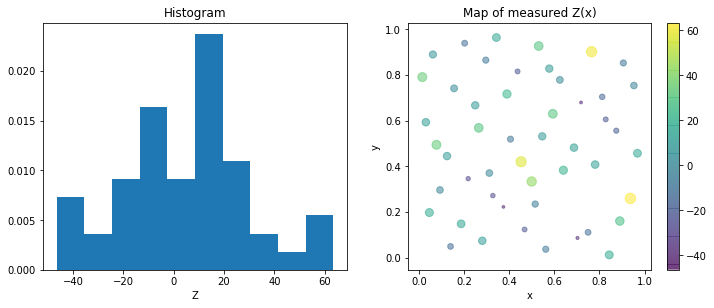

In [15]:
# Plot the data for visual check
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.hist(v, density=True, cumulative=False, histtype='bar')
plt.xlabel('Z')
plt.title('Histogram')

plt.subplot(222)
v.shape=(n,)
s = v-np.min(v)
plt.scatter(x[:,0], x[:,1], s=s, c=v, alpha=0.5)
plt.title('Map of measured Z(x)')

plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

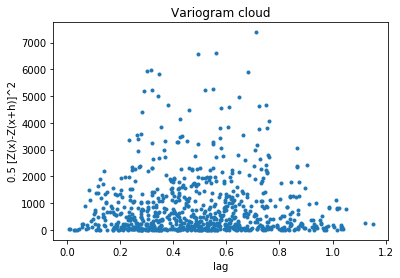

In [14]:
# Defines an object of type experimental variogram. This action precomputes the 
# variogram cloud to accelerate experimental variogram computation.

expvario = geo.ExperimentalVariogram( x, v, plot_variogram_cloud=True )


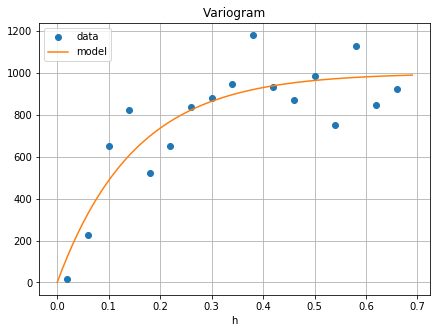

In [18]:
# From the variogram cloud, computes the experimental variogram
he,ge = expvario(hmax=0.7,lag=0.04)

# Defines a variogram model: adapt the range, sill and type
#variomod = geo.variogram( 0.5, 8600, typ='linear' , nugget=0.1)
#variomod = geo.variogram( 0.4, 900, typ='spherical' , nugget=0.1)
variomod = geo.Variogram( 0.45, 1000, typ='exponential' , nugget=0.1)

# Superposes the plot of the two curves for manual fitting
hplot = np.arange(0,0.7,0.01)

plt.figure(figsize=(7,5))
plt.plot(he,ge,'o',label='data')
plt.plot(hplot,variomod(hplot),label='model')
plt.grid()
plt.legend()
plt.title('Variogram')
plt.xlabel('h')
plt.show()

Variogram:  exponential variogram: range = 0.45, sill =1000, nugget =0.1
Acceptable mean normalized error: Q1 = -0.0246247417411 <=  0.32025630761017426
Acceptable mean squared normalized error: Q2 = 0.858967457619
   within bounds LU = [ 0.606521142502 1.49025794192 ]
Geometric mean square error = 117.745636903
Geometric mean error variance = 659.179046529


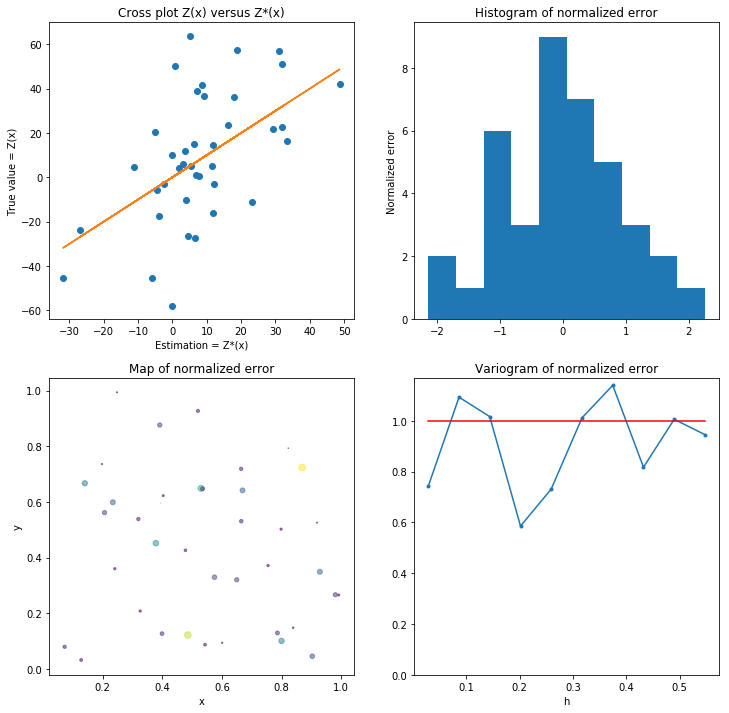

(-0.024624741741085081,
 0.85896745761875315,
 117.74563690263608,
 659.17904652885943)

In [19]:
# Here we create a cross_validation object. The idea is to use that object to store
# the data set and then make multiple cross validation test with different models.
# So, we just initialize the object here. Internally, the function stores the required
# information and precomputes some basic statistics.

ctest = geo.CrossValid( x, v )

print( 'Variogram: ',variomod )
ctest( variomod )

In [29]:
test = range(800,1900,100)
Q1_test, Q12_test, Q2_test, Cr_test, gM_test = [], [], [], [], []
for i in range(len(test)):
    vario = geo.Variogram( 0.35, test[i], typ='exponential' , nugget=0.1)
    print('--- ',vario)
    Q1,Q2,gM,Cr = ctest( vario, makeplot=False)
    Q1_test.append(Q1)
    Q12_test.append((Q2-1.0)**2)
    Q2_test.append(Q2)
    Cr_test.append(Cr)
    gM_test.append(gM)
    print(' ')

---  exponential variogram: range = 0.35, sill =800, nugget =0.1
Acceptable mean normalized error: Q1 = -0.204468451667 <=  0.32025630761017426
Model must be REJECTED:  mean squared normalized error: Q2 = 1.54235624506
   out of bounds LU = [ 0.606521142502 1.49025794192 ]
Geometric mean square error = 326.788025148
Geometric mean error variance = 617.565699434
 
---  exponential variogram: range = 0.35, sill =900, nugget =0.1
Acceptable mean normalized error: Q1 = -0.192778952936 <=  0.32025630761017426
Acceptable mean squared normalized error: Q2 = 1.37101938469
   within bounds LU = [ 0.606521142502 1.49025794192 ]
Geometric mean square error = 326.787104601
Geometric mean error variance = 694.743478504
 
---  exponential variogram: range = 0.35, sill =1000, nugget =0.1
Acceptable mean normalized error: Q1 = -0.182889397119 <=  0.32025630761017426
Acceptable mean squared normalized error: Q2 = 1.23394340804
   within bounds LU = [ 0.606521142502 1.49025794192 ]
Geometric mean square

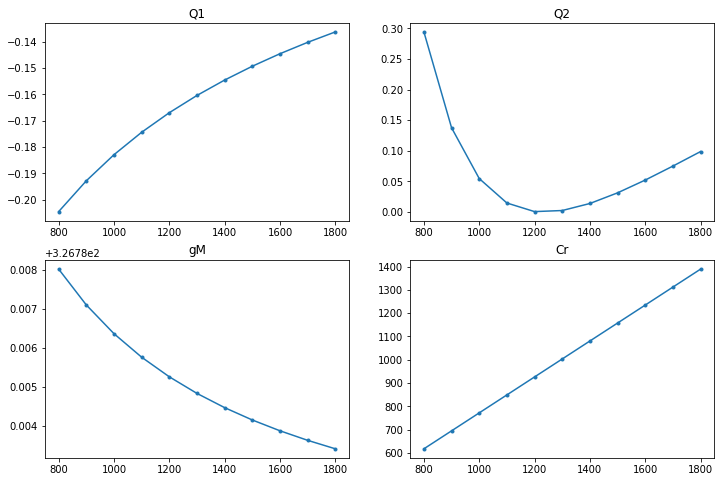

In [30]:
plt.figure( figsize=(12,8) )

plt.subplot(221)
plt.plot(test,Q1_test,'.-')
plt.title('Q1')

plt.subplot(222)
plt.plot(test,Q12_test,'.-')
plt.title('Q2')

plt.subplot(223)
plt.plot(test,gM_test,'.-')
plt.title('gM')

plt.subplot(224)
plt.plot(test,Cr_test,'.-')
plt.title('Cr')

plt.show()

In [25]:
for i in 0.3,0.35,0.4:
    vario = geo.Variogram(rang=i, sill=1300, typ="exponential")
    print('--- ',vario)
    ctest( vario, makeplot=False)
    print(' ')


---  exponential variogram: range = 0.3, sill =1400, nugget =0
Acceptable mean normalized error: Q1 = 0.0596012694941 <=  0.32025630761017426
Acceptable mean squared normalized error: Q2 = 0.919229596693
   within bounds LU = [ 0.606521142502 1.49025794192 ]
Geometric mean square error = 370.253548479
Geometric mean error variance = 1056.32030014
 
---  exponential variogram: range = 0.35, sill =1400, nugget =0
Acceptable mean normalized error: Q1 = 0.0650361158908 <=  0.32025630761017426
Acceptable mean squared normalized error: Q2 = 0.993528916684
   within bounds LU = [ 0.606521142502 1.49025794192 ]
Geometric mean square error = 382.225564044
Geometric mean error variance = 984.42585004
 
---  exponential variogram: range = 0.4, sill =1400, nugget =0
Acceptable mean normalized error: Q1 = 0.070231428977 <=  0.32025630761017426
Acceptable mean squared normalized error: Q2 = 1.07309275022
   within bounds LU = [ 0.606521142502 1.49025794192 ]
Geometric mean square error = 380.5274921

exponential variogram: range = 0.4, sill =950, nugget =0.1


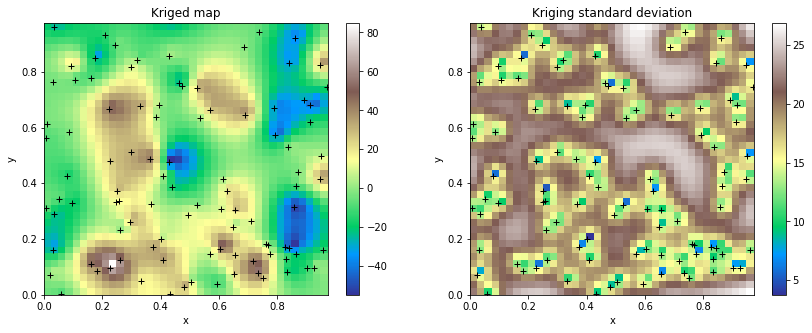

In [12]:
xs = np.arange(0, 1, 0.025)
nx = len(xs)
xx, yy = np.meshgrid(xs, xs)

xx.shape = (nx*nx,1)
yy.shape = (nx*nx,1)

xu = np.zeros( (nx*nx,2) )
xu[:,0] = xx[:,0]
xu[:,1] = yy[:,0]

vu, stdu = geo.ordinary_kriging_variogram(x,v,xu,variomod)


print(variomod)

xx.shape = (nx,nx)
yy.shape = (nx,nx)
vu.shape = (nx,nx)
stdu.shape = (nx,nx)

v.shape=(n,)

fig, (ax0, ax1) = plt.subplots( figsize=(14,5), ncols=2 )
cmap = plt.get_cmap('terrain')

cf = ax0.pcolormesh(xx, yy, vu, cmap=cmap  )
ax0.axis('tight')
ax0.plot(x[:,0], x[:,1],'k+')
ax0.set_title('Kriged map')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
fig.colorbar(cf, ax=ax0)

cf = ax1.pcolormesh(xx, yy, np.sqrt(stdu), cmap=cmap  )
ax1.axis('tight')
ax1.plot(x[:,0], x[:,1],'k+')
ax1.set_title('Kriging standard deviation')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(cf, ax=ax1)

plt.show()

In [ ]:
xs = np.arange(0, 1, 0.025)
nx = len(xs)
xx, yy = np.meshgrid(xs, xs)

xx.shape = (nx*nx,1)
yy.shape = (nx*nx,1)

xu = np.zeros( (nx*nx,2) )
xu[:,0] = xx[:,0]
xu[:,1] = yy[:,0]

vu, stdu = geo.ordinary_kriging_variogram(x,v,xu,variomod)

print(variomod)


xx.shape = (nx,nx)
yy.shape = (nx,nx)
vu.shape = (nx,nx)
stdu.shape = (nx,nx)

v.shape=(n,)

fig, (ax0, ax1) = plt.subplots( figsize=(14,5), ncols=2 )
cmap = plt.get_cmap('terrain')

cf = ax0.pcolormesh(xx, yy, vu, cmap=cmap  )
ax0.axis('tight')
ax0.plot(x[:,0], x[:,1],'k+')
ax0.set_title('Kriged map')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
fig.colorbar(cf, ax=ax0)

cf = ax1.pcolormesh(xx, yy, np.sqrt(stdu), cmap=cmap  )
ax1.axis('tight')
ax1.plot(x[:,0], x[:,1],'k+')
ax1.set_title('Kriging standard deviation')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(cf, ax=ax1)

plt.show()